!pip install rrcf

In [1]:
import numpy as np
import pandas as pd

In [2]:
from utils.datasets import GhlKasperskyDataset, TepHarvardDataset, TepKasperskyDataset
from utils.custom_plots import plot_stacked

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

In [4]:
import rrcf

In [5]:
from adtk.metrics import precision, recall, f1_score
from utils.metrics import time_span_metrics

In [6]:
from tqdm.notebook import tqdm

# Get data from datasets

In [7]:
ds_ghl = GhlKasperskyDataset()
ds_ghl.shake_not_stir(valid_test_ratio=0.3)
train_ghl, _, _= next(ds_ghl.train_generator())
valid_ghl, faults_ghl, info_ghl= next(ds_ghl.valid_generator())

In [8]:
ds_tep1 = TepHarvardDataset()
ds_tep1.shake_not_stir(balanced_test=True, valid_test_ratio=1.0)
train_tep1, _, _= next(ds_tep1.train_generator())
valid_tep1, faults_tep1, info_tep1= next(ds_tep1.valid_generator())

In [9]:
ds_tep2 = TepHarvardDataset()
ds_tep2.shake_not_stir(valid_test_ratio=0.3)
train_tep2, _, _= next(ds_tep2.train_generator())
valid_tep2, faults_tep2, info_tep2= next(ds_tep2.valid_generator())

# IsolationForest test

## GHL

In [10]:
isoforest = IsolationForest(n_estimators=1000,
                            max_samples='auto',
                            contamination='auto',
                            max_features=1.0,
                            bootstrap=False,
                            n_jobs=-1,
                            random_state=31,
                            verbose=1,
                            warm_start=False)

In [11]:
isoforest.fit(train_ghl)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.0s remaining:    9.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.1s finished


IsolationForest(n_estimators=1000, n_jobs=-1, random_state=31, verbose=1)

In [12]:
detect = pd.Series(index=valid_ghl.index, data=isoforest.predict(valid_ghl))
detect.replace({1: 0, -1: 1}, inplace=True)

In [13]:
time_span_metrics(faults_ghl, detect)

(0.010416666666666666, 1.0, 0.020618556701030927)

In [14]:
# Set parameters
np.random.seed(0)
n = 2010
d = 3
num_trees = 100
tree_size = 256

# Generate data
X = np.zeros((n, d))
X[:1000,0] = 5
X[1000:2000,0] = -5
X += 0.01*np.random.randn(*X.shape)


rcforest = []
while len(rcforest) < num_trees:
    # Select random subsets of points uniformly from point set
    ixs = np.random.choice(n, 
                           size=(n // tree_size, tree_size),
                           replace=False,
                          )
    # Add sampled trees to forest
    trees = [rrcf.RCTree(X[ix], index_labels=ix) for ix in ixs]
    rcforest.extend(trees)

In [15]:
# Compute average CoDisp
avg_codisp = pd.Series(0.0, index=np.arange(n))
index = np.zeros(n)
for tree in rcforest:
    codisp = pd.Series({leaf : tree.codisp(leaf) for leaf in tree.leaves})
    avg_codisp[codisp.index] += codisp
    np.add.at(index, codisp.index.values, 1)
avg_codisp /= index

<AxesSubplot:>

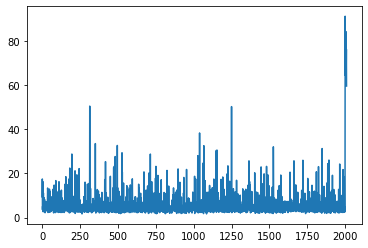

In [16]:
avg_codisp.plot()

In [17]:
# Generate data
n = 730
A = 50
center = 100
phi = 30
T = 2*np.pi/100
t = np.arange(n)
sin = A*np.sin(T*t-phi*T) + center
sin[235:255] = 80

# Set tree parameters
num_trees = 40
shingle_size = 4
tree_size = 256

# Create a forest of empty trees
forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)
    
# Use the "shingle" generator to create rolling window
points = rrcf.shingle(sin, size=shingle_size)

# Create a dict to store anomaly score of each point
avg_codisp = {}

# For each shingle...
for index, point in enumerate(points):
    # For each tree in the forest...
    for tree in forest:
        # If tree is above permitted size, drop the oldest point (FIFO)
        if len(tree.leaves) > tree_size:
            tree.forget_point(index - tree_size)
        # Insert the new point into the tree
        tree.insert_point(point, index=index)
        # Compute codisp on the new point and take the average among all trees
        if not index in avg_codisp:
            avg_codisp[index] = 0
        avg_codisp[index] += tree.codisp(index) / num_trees

## TEP Harvard

In [18]:
isoforest = IsolationForest(n_estimators=100,
                            max_samples='auto',
                            contamination='auto',
                            max_features=1.0,
                            bootstrap=False,
                            n_jobs=-1,
                            random_state=31,
                            verbose=1,
                            warm_start=False)

In [19]:
isoforest.fit(train_tep1.values)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


IsolationForest(n_jobs=-1, random_state=31, verbose=1)

In [20]:
detect = pd.Series(index=valid_tep1.index, data=isoforest.predict(valid_tep1.values))
detect.replace({1: 0, -1: 1}, inplace=True)

In [21]:
time_span_metrics(faults_tep1, detect)

(1.0, 0.9791666666666666, 0.9894736842105263)

## TEP Kaspersky

In [22]:
isoforest = IsolationForest(n_estimators=100,
                            max_samples='auto',
                            contamination='auto',
                            max_features=1.0,
                            bootstrap=False,
                            n_jobs=-1,
                            random_state=31,
                            verbose=1,
                            warm_start=False)

In [23]:
isoforest.fit(train_tep2.values)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


IsolationForest(n_jobs=-1, random_state=31, verbose=1)

In [24]:
detect = pd.Series(index=valid_tep2.index, data=isoforest.predict(valid_tep2.values))
detect.replace({1: 0, -1: 1}, inplace=True)

In [25]:
time_span_metrics(faults_tep2, detect)

(1.0, 0.3541666666666667, 0.5230769230769231)

# Watchman test

In [26]:
from utils.watchmen import IsolatedWatchman

## GHL

In [27]:
watchman_ghl = IsolatedWatchman(random_state=31)

In [28]:
ds_ghl.shake_not_stir(valid_test_ratio=0.3)

In [29]:
# learn data
train_gen = ds_ghl.train_generator()
for train, _, _ in tqdm(train_gen):
    watchman_ghl.partial_fit(train)

0it [00:00, ?it/s]

In [30]:
train.shape

(25001, 12)

In [31]:
# examine
valid_gen = ds_ghl.valid_generator()
examine_list = pd.DataFrame(columns=['precision', 'recall', 'f1_score'], dtype='float')
for valid, faults, info in tqdm(valid_gen):
    detect = watchman_ghl.predict(valid)
    examine_list.loc[info] = time_span_metrics(faults, detect)
print(examine_list.mean())

0it [00:00, ?it/s]

precision    0.015105
recall       0.862925
f1_score     0.029501
dtype: float64


In [32]:
watchman_ghl

IsolatedWatchman(n_trees=97)

## TEP Harvard

In [33]:
watchman_tep1 = IsolatedWatchman(random_state=31)

In [34]:
ds_tep1.shake_not_stir(balanced_test=True, valid_test_ratio=0.5)

In [36]:
# learn data
train_gen = ds_tep1.train_generator()
for train, _, _ in tqdm(train_gen, total=500):
    watchman_tep1.partial_fit(train)

  0%|          | 0/500 [00:00<?, ?it/s]

In [37]:
# examine
valid_gen = ds_tep1.valid_generator()
examine_list = pd.DataFrame(columns=['precision', 'recall', 'f1_score'], dtype='float')
for valid, faults, info in tqdm(valid_gen, total=500):
    detect = watchman_tep1.predict(valid)
    examine_list.loc[info] = time_span_metrics(faults, detect)
#     if max(faults) and max(detect_vector) and 'fault_011' in info:
#         plot_stacked(test, faults=faults, detect=detect_vector)
#         break
print(examine_list.mean())

  0%|          | 0/500 [00:00<?, ?it/s]

precision    0.999719
recall       0.529063
f1_score     0.611234
dtype: float64


In [38]:
watchman_tep1

IsolatedWatchman(n_trees=500)